# MNIST Adder Network using Pytorch

Input


*   Image from MNIST dataset
*   Random Number

Output



*   Predict number in binary format from MNIST image
*   Add random number and predicted number and output in binary format of the summation.








## Necessary imports


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
from sklearn import preprocessing

import matplotlib.pyplot as plt
import numpy as np

import random
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

## Dataset preparation


*   Define transforms
*   Download MNIST dataset
*   Creation of custom dataset with Random number
*   Dataloader for the given batch size





### Define transforms

In [2]:

train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])




### Download MNIST

In [3]:
train_set = torchvision.datasets.MNIST('/data', train=True, download=True, transform=train_transforms)
train_set, val_set = torch.utils.data.random_split(train_set, [50000, 10000])
test_set = torchvision.datasets.MNIST('/data', train=False, download=True, transform=test_transforms)


Extracting /data/MNIST/raw/train-images-idx3-ubyte.gz to /data/MNIST/raw




Extracting /data/MNIST/raw/train-labels-idx1-ubyte.gz to /data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /data/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/MNIST/raw




Extracting /data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Custom dataset class (MNIST + Random Number)



In [4]:
# For MNIST

class_labels_mnist = ['00000', '00001', '00010', '00011', '00100', '00101', '00110', '00111', '01000', '01001']
label_encoder_mnist = preprocessing.LabelEncoder()
targets_mnist = label_encoder_mnist.fit_transform(class_labels_mnist)


# For summation 

class_labels_summation = ['00000', '00001', '00010', '00011', '00100', '00101', '00110', '00111', '01000', '01001', '01010', '01011', '01100', '01101', '01110', '01111', '10000', '10001', '10010']
label_encoder_summation = preprocessing.LabelEncoder()
targets_summation = label_encoder_summation.fit_transform(class_labels_summation)

In [5]:
class CustomMNIST(Dataset):
  def __init__(self, MNIST):
    self.MNIST = MNIST
    self.binary_label_list = { 0:"00000", 1:"00001", 2:"00010", 3:"00011", 4:"00100", 5:"00101", 6:"00110", 7:"00111", 8:"01000", 9:"01001", 10:"01010", 11: "01011", 12:"01100", 13:"01101", 14:"01110", 15:"01111", 16:"10000", 17:"10001", 18:"10010"} 

  def get_binary_number(self,number):
    binary_number = self.binary_label_list[number]
    return binary_number

  def __getitem__(self, index):
    mnist_image = self.MNIST[index][0]
    label = self.MNIST[index][1]

    label_binary = self.get_binary_number(label)
    binary_target = targets_mnist[class_labels_mnist.index(label_binary)]


    random_number = random.randint(0,9)
    
    # One hot encoding vector for random number  
    one_hot_encoding_random_number = torch.nn.functional.one_hot(torch.arange(0, 10))

    #Summation
    sum_output = label + random_number

    sum_target = targets_summation[class_labels_summation.index(self.get_binary_number(sum_output))]
    # print("label binary target", label, binary_target)
    return mnist_image, binary_target , one_hot_encoding_random_number[random_number], sum_target

  def __len__(self):
    return len(self.MNIST)

train_dataset = CustomMNIST(train_set)
val_dataset = CustomMNIST(val_set)
test_dataset = CustomMNIST(test_set)    

### Dataloader


In [6]:
batch_size = 64
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=batch_size)
test_loader = DataLoader(test_dataset,batch_size=batch_size)

### Sample batch




In [7]:
sample_batch = iter(train_loader)
mnist_image, binary_labels, random_number, binary_sum_output = sample_batch.next()

print(" Mnist binary label:", class_labels_mnist[binary_labels[0]])
print(" Random number:", random_number[0])
print(" Summation output in binary:", class_labels_summation[binary_sum_output[0]])

 Mnist binary label: 01001
 Random number: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
 Summation output in binary: 01001


## Defining the Model

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)       #Input: 28*28*1    Output:28 * 28 * 32    Receptive Field:3 * 3  
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)      #Input: 28*28*32   Output:28 * 28 * 64    Receptive Field:5 * 5
        self.pool1 = nn.MaxPool2d(2, 2)                   #Input: 28*28*64   Output:14 * 14 * 64    Receptive Field:10*10 
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)     #Input: 14*14*64   Output:14 * 14 * 128   Receptive Field:12*12
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)    #Input: 14*14*128  Output:14 * 14 * 256   Receptive Field:14*14
        self.pool2 = nn.MaxPool2d(2, 2)                   #Input: 14*14*256  Output: 7 * 7 * 256    Receptive Field:28*28
        self.conv5 = nn.Conv2d(256, 256, 3, padding=1)    #Input: 7*7*256    Output: 7 * 7 * 256     Receptive Field:30*30
        self.conv6 = nn.Conv2d(256, 10, 3, padding=1)     #Input: 7*7*356     Output: 7 * 7 * 10   Receptive Field:32*32
        self.gap = nn.AvgPool2d(kernel_size=7) # GAP layer

        self.fc1 = nn.Linear(20, 128)                  # 10 from convolution output another 10 from one hot encoding of random number 
        self.fc2 = nn.Linear(128, 19)

    def forward(self, image, randomNumber):
        
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(image)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = self.conv6(F.relu(self.conv5(x)))
        x = self.gap(x)
        x = x.view(-1, 10)
        
        # Concatenate second input to the output from above convolution
        x1 = torch.cat((x, randomNumber), dim=1)
        
        # Fully connected layers
        x1 = F.relu(self.fc1(x1))
        x1 = self.fc2(x1)          
        return F.log_softmax(x, dim = 1), F.log_softmax(x1, dim = 1)




## The Model

In [19]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# move the model to the specified device
model = Net().to(device)
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (gap): AvgPool2d(kernel_size=7, stride=7, padding=0)
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=19, bias=True)
)

## Training Loop

In [20]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    epoch_loss = 0

    for batch_idx, (mnist_image, binary_label, random_number, binary_summation) in enumerate(train_loader):

        # Converting to torch.LongTensor because loss functions needs in that mnist_imagetype
        binary_label = binary_label.type(torch.LongTensor)
        binary_summation = binary_summation.type(torch.LongTensor)

        # Moving  to GPU
        mnist_image, binary_label, binary_summation = mnist_image.to(device), binary_label.to(device), binary_summation.to(device)

        # zero out the gradients
        optimizer.zero_grad()

        # Output from model (Forward pass)
        output, binary_summation_output = model(mnist_image,random_number.to(device))

        # compute the loss occured
        mnist_loss = F.nll_loss(output, binary_label)
        addition_loss = F.nll_loss(binary_summation_output, binary_summation)
        loss= (mnist_loss + addition_loss)/2

        epoch_loss += loss.item()

        # Backprop
        loss.backward()

        # update the optimizer params
        optimizer.step()
    print('Train set: Average loss: {:.4f}'.format(loss.item()))

    train_loss = epoch_loss / len(train_loader)
    return train_loss



## Testing Loop

In [21]:
def test(model, device, test_loader,test_type='Val'):
    # set the model in evaluation model
    model.eval()

    # set the loss to zero
    test_loss = 0
    
    # the number of correct classifications
    correct_mnist = 0
    correct_addition = 0

    with torch.no_grad():
        for (mnist_image, binary_label, random_number, binary_sum) in test_loader:

            # moving to GPU
            binary_label = binary_label.type(torch.LongTensor)
            binary_sum = binary_sum.type(torch.LongTensor)
            mnist_image, binary_label,binary_sum = mnist_image.to(device), binary_label.to(device), binary_sum.to(device)

            # Model inference
            output, binary_sum_output = model(mnist_image,random_number.to(device))

            # Total loss
            mnist_network_loss = F.nll_loss(output, binary_label, reduction='sum').item()
            summation_network_loss =F.nll_loss(binary_sum_output, binary_sum, reduction='sum').item()
            test_loss += ( mnist_network_loss + summation_network_loss )/2

            mnist_pred = output.argmax(dim=1, keepdim=True)
            addition_pred = binary_sum_output.argmax(dim=1, keepdim=True)

           # Calculating total correct preds
            correct_mnist += mnist_pred.eq(binary_label.view_as(mnist_pred)).sum().item()
            correct_addition += addition_pred.eq(binary_sum.view_as(addition_pred)).sum().item()


    
    test_loss /= len(test_loader.dataset)
    print(f'{test_type} set: Average loss: {test_loss:.3f}, MNist Accuracy:{100. * correct_mnist/len(test_loader.dataset)}, binary_sum_Accuracy:{100. * correct_addition/len(test_loader.dataset)}')

    return test_loss


## Let's write train and test the model

In [22]:
# Moving model to GPU
model = Net().to(device)

# defining optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# Number of epochs
num_epoch = 15
train_loss_values = []
valid_loss_values = []


for epoch in range(1, num_epoch+1):
    print('\nEpoch {} : '.format(epoch))
    train_loss = train(model, device, train_loader, optimizer, epoch)
    valid_loss = test(model, device, val_loader)
    train_loss_values.append(train_loss)
    valid_loss_values.append(valid_loss)


Epoch 1 : 
Train set: Average loss: 2.5178
Val set: Average loss: 2.527, MNist Accuracy:12.52, binary_sum_Accuracy:9.76

Epoch 2 : 
Train set: Average loss: 1.2684
Val set: Average loss: 1.614, MNist Accuracy:79.17, binary_sum_Accuracy:11.5

Epoch 3 : 
Train set: Average loss: 1.2941
Val set: Average loss: 1.374, MNist Accuracy:89.97, binary_sum_Accuracy:14.08

Epoch 4 : 
Train set: Average loss: 1.0522
Val set: Average loss: 1.202, MNist Accuracy:95.7, binary_sum_Accuracy:22.95

Epoch 5 : 
Train set: Average loss: 1.1505
Val set: Average loss: 1.131, MNist Accuracy:96.3, binary_sum_Accuracy:29.71

Epoch 6 : 
Train set: Average loss: 1.2588
Val set: Average loss: 1.061, MNist Accuracy:96.65, binary_sum_Accuracy:37.54

Epoch 7 : 
Train set: Average loss: 0.8083
Val set: Average loss: 0.973, MNist Accuracy:97.26, binary_sum_Accuracy:45.15

Epoch 8 : 
Train set: Average loss: 0.8588
Val set: Average loss: 0.929, MNist Accuracy:96.42, binary_sum_Accuracy:48.64

Epoch 9 : 
Train set: Avera

## Ploting the loss 

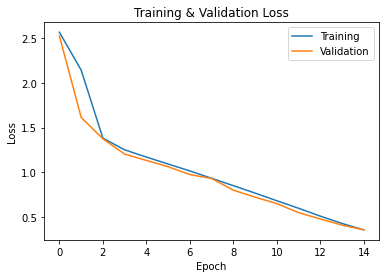

In [23]:

# Plot the learning curve.
plt.plot(np.array(train_loss_values), label="Training")
plt.plot(np.array(valid_loss_values), label="Validation")


# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Sample inference on test data 

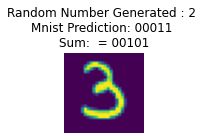

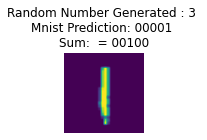

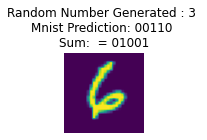

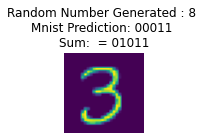

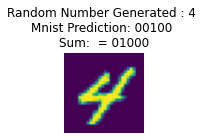

In [25]:
for _ in range(0,5):
  image,_,_,_ = test_dataset[random.randint(1,10000)]
  random_number=random.randint(0,9)

  random_number_one_hot = torch.zeros(11).long()
  random_number_one_hot[random_number] = 1
  random_number_one_hot = random_number_one_hot[:-1]

  mnist_net_output, adder_net_output = model(image.unsqueeze(dim=1).to(device),random_number_one_hot.reshape(-1,10).to(device))

  mnist_pred = mnist_net_output.argmax(dim=1, keepdim=True)
  sum_pred = adder_net_output.argmax(dim=1, keepdim=True)
  mnist_binary = class_labels_mnist[mnist_pred.item()]
  summation_binary = class_labels_summation[sum_pred.item()]


  fig = plt.figure(figsize=(5, 5))
  ax = fig.add_subplot(3, 3, 1)
  ax.axis('off')
  ax.imshow(image.cpu().numpy().squeeze())
  ax.set_title(f'Random Number Generated : {random_number} \n'
                f'Mnist Prediction: {mnist_binary} \n'
                f'Sum:  = {summation_binary}')
